<a href="https://colab.research.google.com/github/shizoda/education/blob/main/machine_learning/cnn/cifar10_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNNでの画像分類

## CNNとは

CNN (Convolutional Neural Network，畳み込みニューラルネットワーク )は、特に画像や映像の認識，解析において高い性能を発揮するディープラーニングの一種です．CNNは，入力データから特徴を自動的に学習し，識別や分類を行う能力を持っています．以下に，CNNの構造，動作原理，主な用途について説明します．

<a title="Aphex34, CC BY-SA 4.0 &lt;https://creativecommons.org/licenses/by-sa/4.0&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Typical_cnn.png"><img width="512" alt="Typical cnn" src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/63/Typical_cnn.png/512px-Typical_cnn.png?20151217030420"></a>

### 主な構成要素
CNNはディープラーニングの中でも，畳み込み層やプーリング層といった独自の構造を持っていることが特徴です．以下では主な構成要素について説明します．

- 畳み込み層

畳み込み層は，画像内の局所的な特徴抽出を行います．隣接するピクセル間におけるエッジや色の変化といった局所的な特徴を検出し，画像内の情報を保持しつつ，高度な特徴抽出を実現します．

<a title="Michael Plotke, CC BY-SA 3.0 &lt;https://creativecommons.org/licenses/by-sa/3.0&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:2D_Convolution_Animation.gif"><img width="256" alt="2D Convolution Animation" src="https://upload.wikimedia.org/wikipedia/commons/1/19/2D_Convolution_Animation.gif?20130203224852"></a>

- プーリング層

プーリング層では，畳み込み層で抽出された特徴が移動しても影響を受けないようにする役割を担います．畳み込み層から出力される特徴は局所的なものです．対象の特徴を維持しながら位置に関する情報をそぎ落とすことで，重要な情報のみを保持し，特徴量のサイズを小さくすることができます．

最大プーリングと平均プーリングが有名です．

<a title="Muhamad Yani, et al.; Creative Commons Attribution 3.0 Unported &lt;https://creativecommons.org/licenses/by/3.0/&gt;" href="https://www.researchgate.net/figure/Illustration-of-Max-Pooling-and-Average-Pooling-Figure-2-above-shows-an-example-of-max_fig2_333593451"><img width = "256" alt ="Creative Commons Attribution 3.0 Unported" src="https://www.researchgate.net/publication/333593451/figure/fig2/AS:765890261966848@1559613876098/Illustration-of-Max-Pooling-and-Average-Pooling-Figure-2-above-shows-an-example-of-max.png"></a>

- 全結合層

畳み込み層やプーリング層で抽出された特徴を基に，最終的な分類や予測を行う層です．分類であれば，入力データがどのクラスに属するかを決定します．

## CNN での画像分類

ここでは単純な CNN モデルを画像分類用にトレーニングし、評価します。

データセットとして [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) を用います．CIFAR-10 は、10 の異なるクラス（飛行機、自動車、鳥、猫など）に属する全 60,000 枚の小さなカラー画像（32x32ピクセル）を含むデータセットです。

**実行する場合には、Google Colab の GPU ランタイムをオンにしてください**

<img src="https://raw.githubusercontent.com/shizoda/education/main/machine_learning/cnn/runtime1.png" height="300"> <img src="https://raw.githubusercontent.com/shizoda/education/main/machine_learning/cnn/runtime2.png" height="300">

### PyTorch のインポート

深層学習のための主要なフレームワークとして、Google が開発した TensorFlow と、Meta (Facebook) が開発した PyTorch が有名です。今回は PyTorch を使用します。

<a title="PyTorch, BSD &lt;http://opensource.org/licenses/bsd-license.php&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:PyTorch_logo_black.svg"><img width="256" alt="PyTorch logo black" src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/c6/PyTorch_logo_black.svg/256px-PyTorch_logo_black.svg.png?20200318230141"></a>

前述のとおり、高速な並列演算のために GPU を使用します。使用できる状態であることを確認しています。

In [1]:
# PyTorch 関連のライブラリをインポートします
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split

# GPU が利用可能であることを確認
assert torch.cuda.is_available(), "GPU が使えません。ランタイムの設定を確認してください。"


### データのロード

CIFAR-10データセットをダウンロードします。

- 学習に用いる **学習**データセット

- 学習中に精度を調べ，早期停止に用いる **検証**データセット

- 学習後に精度を調べる **テスト**データセット

の各データセットとなります。ちなみに

- `transforms.Compose` は、データに適用する一連の前処理手順を定義します。この例では、画像を numpy 配列から「PyTorch テンソル」とよばれる形式に変換して、PyTorch が扱えるようにしています。

- `DataLoader` は、大量にあるデータをミニバッチ (mini-batch) という単位で少しずつ取り出せるようにするものです。今回は画像を 100 枚ずつ取り出します。

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 学習用データセットをロードし、検証用データセットに分割
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_size = int(0.8 * len(trainset))
validation_size = len(trainset) - train_size
train_dataset, validation_dataset = random_split(trainset, [train_size, validation_size])

# ミニバッチ (mini-batch) サイズを100とし、学習用データローダと検証用データローダを定義
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
validationloader = torch.utils.data.DataLoader(validation_dataset, batch_size=100, shuffle=False)

# テスト用データセットをロード
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170498071/170498071 [00:21<00:00, 7984856.72it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


ダウンロードできたところで、いくつか画像を見てみましょう。

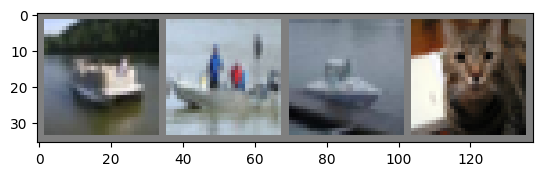

ship  ship  ship  cat  


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 画像を表示するためのヘルパー関数
def imshow(img):
    img = img / 2 + 0.5     # 正規化を元に戻す
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# DataLoader から画像を取得して表示する関数
def show_images(dataloader, num_images):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)  # バッチを一つ取得

    # 画像を表示
    imshow(torchvision.utils.make_grid(images[:num_images]))
    # 正解ラベルを表示
    print(' '.join(f'{classes[labels[j]]:5s}' for j in range(num_images)))

# 使用例：trainloader から 4 枚の画像を表示
show_images(trainloader, 4)


### CNN モデルの定義

`forward` メソッドを１行ずつ確認して、どのような構成になっているか確認してみましょう。

畳み込み層の後には ReLu という活性化関数を入れています。[活性化関数って？ (Zenn)](https://zenn.dev/nekoallergy/articles/ml-basic-act-01)

In [4]:
# Net クラスは、CNNモデルのアーキテクチャを定義します。
# モデルは畳み込み層（nn.Conv2d）、プーリング層（nn.MaxPool2d）、全結合層（nn.Linear）から構成されています。
# forward メソッドは、ネットワークを通じて入力がどのように進むかを定義します

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):

        # 畳み込み層１
        x = self.conv1(x)
        x = F.relu(x) # 活性化関数

        # プーリング層
        x = self.pool(x)

        # 畳み込み層２
        x = self.conv2(x)
        x = F.relu(x) # 活性化関数

        # プーリング層２
        x = self.pool(x)

        # 全結合層
        x = x.view(-1, 16 * 5 * 5)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)

        return x

# インスタンス化。Net クラス（設計図）のオブジェクト（実体）を net とする
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = Net().to(device)

### 損失関数とオプティマイザ

**損失関数**（誤差関数，ロスともいう）`nn.CrossEntropyLoss` は、モデルの予測と実際のラベル間の差異を測定します。

オプティマイザ `optim.SGD` は、モデルのパラメータを調整するために使用されます。ほかに Adam が有名です。

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 学習

学習データセットから画像をランダムに数枚取り出した **ミニバッチ** (mini-batch) をネットワークに入力すると，何らかの出力が得られます．上記の損失関数によって出力と正解を比較し，「出力がどれくらい正解に近いか」を評価します．損失の値が小さいほど，正解に近いことを表します．

それを繰り返しつつ，少しずつ損失を小さくするようにネットワークの重み（畳み込みに用いるカーネル）を更新していきます．この更新の仕組みは **誤差逆伝播法** (back-propagation) とよばれます．損失が小さくなる様子をグラフで確認してみてください．損失が小さくなっていくということは，画像に対して正解に近い出力が得られるようになってくることを意味します．

毎回、学習に使用しない検証データに対しても誤差を計算します。この誤差が一定回数改善しない場合は学習を終了します。学習しすぎると **過学習** を起こすことがあるためです。<br>[機械学習における過学習とは何か？ (TRIETING)](https://www.tryeting.jp/column/6846/)

更新はミニバッチごとに行われ，今回はミニバッチ１個あたり100枚の画像となっています（冒頭付近での設定）．それを繰り返して，ひととおり学習データをすべて使い切ることを 1 **エポック** と数えます．今回は最大10エポックの学習を行うこととしています．

In [6]:
max_epoch = 10     # 最大エポック数
patience = 5       # 改善が見られないエポック数の許容回数
trigger_times = 0  # 改善が見られないエポック数のカウンター

best_val_loss = float("inf")  # 初期値として無限大を設定
train_losses = []  # 学習データセットの損失を保存するリスト
val_losses = []  # 検証データセットの損失を保存するリスト

# エポック数のループ
for epoch in range(max_epoch):
    running_loss = 0.0

    # 学習データセットからミニバッチを得るたびに…
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)  # 入力データをGPUに送る
        labels = labels.to(device)  # ラベルをGPUに送る

        optimizer.zero_grad()  # 勾配の初期化

        outputs = net(inputs)  # ネットワークに入力データを渡して出力を取得
        loss = criterion(outputs, labels)  # 損失を計算
        loss.backward()  # 逆伝播を行い、勾配を計算
        optimizer.step()  # パラメータを更新

        running_loss += loss.item()  # ミニバッチの損失を累積

    # エポックごとの訓練データセットに対する平均損失を計算
    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)

    # 検証データセットに対する損失を計算
    val_loss = 0.0
    net.eval()  # モデルを評価モードに切り替える
    with torch.no_grad():

        # 検証データセットからミニバッチを得るたびに…
        for data in validationloader:
            images, labels = data
            images = images.to(device)  # 入力データをGPUに送る
            labels = labels.to(device)  # ラベルをGPUに送る

            outputs = net(images)  # ネットワークに入力データを渡して出力を取得
            loss = criterion(outputs, labels)  # 損失を計算
            val_loss += loss.item()  # 損失を累積

    # エポックごとの検証データセットに対する平均損失を計算
    val_loss = val_loss / len(validationloader)
    val_losses.append(val_loss)

    # 損失の値をグラフで表示
    plt.clf()  # 前のグラフをクリア
    plt.plot(train_losses, label='Training loss')  # 訓練データセットの損失
    plt.plot(val_losses, label='Validation loss')  # 検証データセットの損失をプロット
    plt.xlabel('Epoch')  # x軸のラベルを設定
    plt.ylabel('Loss')  # y軸のラベルを設定
    plt.xlim(left=0)  # x軸の表示範囲を設定
    plt.ylim(bottom=0)  # y軸の表示範囲を設定
    plt.legend()  # 凡例を表示
    plt.show()  # グラフを表示

    # エポックごとの損失を出力
    print("Epoch:", epoch + 1)
    print("Train loss     : ", train_loss)
    print("Validation loss: ", val_loss)

    # 検証データセットに対する損失が改善しない場合の処理
    if val_loss < best_val_loss:
        best_val_loss = val_loss  # 最良の検証データセット損失を更新
        trigger_times = 0  # 改善が見られないエポック数をリセット
    else:
        trigger_times += 1  # 改善が見られないエポック数をカウントアップ
        if trigger_times >= patience:  # 許容回数を超えた場合の処理
            print(f"{epoch + 1} エポックで早期終了")  # 早期終了のメッセージを出力
            break  # 学習を終了

print('学習終了')

TypeError: relu() missing 1 required positional argument: 'input'

### テスト
訓練されたモデルを使用してテストデータセット上でのパフォーマンスを評価します。

最終的な精度（正確に分類された画像の割合）を求めることができます。

In [ ]:
correct = 0  # 正解数のカウンターを初期化
total = 0  # 全体の画像数のカウンターを初期化

# 訓練モードでの計算を停止（推論モードに切り替える）
with torch.no_grad():
    # テストデータセットに対してループ
    for data in testloader:
        images, labels = data  # ミニバッチごとの画像とラベルを取得
        images = images.to(device)  # GPUに画像を送る
        labels = labels.to(device)  # GPUにラベルを送る

        outputs = net(images)  # ネットワークに画像を入力し、出力を取得
        _, predicted = torch.max(outputs.data, 1)  # 出力の中で最大の値を持つクラスを予測として取得
        total += labels.size(0)  # ミニバッチ内の画像数を全体の画像数に加算
        correct += (predicted == labels).sum().item()  # 予測が正しい場合、正解数をカウントアップ

# 精度を計算して表示
print('テスト画像における精度 %d %%' % (100 * correct / total))

個々の結果も見てみましょう。

In [ ]:
# テストデータの画像を表示し、正解と推定値を表示する関数
def visualize_test_predictions(start_idx, end_idx):
    # テストデータローダーを作成
    testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                             shuffle=False, num_workers=2)

    # 指定したインデックス範囲の画像とラベルを取得
    images, labels = zip(*[(data[0], data[1]) for i, data in enumerate(testloader) if start_idx <= i < end_idx])

    # モデルの予測結果を格納するリストを初期化
    predicted_labels = []

    # 推論モードで計算を停止
    with torch.no_grad():
        # 画像ごとに予測を行う
        for image in images:
            image = image.to(device)  # GPUに画像を送る
            outputs = net(image)  # ネットワークに画像を入力し、出力を得る
            _, predicted = torch.max(outputs, 1)  # 出力の中で最大の値を持つクラスを予測として取得
            predicted_labels.append(predicted.item())  # 予測結果をリストに追加

    # 画像とラベルを表示
    for i in range(len(images)):
        print(f"画像 {start_idx + i}")
        imshow(torchvision.utils.make_grid(images[i]))  # 画像をグリッド形式で表示
        print(f"正解： {classes[labels[i]]}")  # 正解ラベルを表示
        print(f"推定： {classes[predicted_labels[i]]}\n")  # 予測ラベルを表示

# 例: インデックス範囲 0 から 5 の画像を表示
visualize_test_predictions(0, 5)
